# <a id='toc1_'></a>[컴퓨터비전-Object Detection 기말과제](#toc0_)


## 목차
<a id='toc0_'></a>    
- [컴퓨터비전-Object Detection 기말과제](#toc1_)    
  - [라이브러리 import 및 설정](#toc1_1_)    
  - [데이터 탐색](#toc1_2_)    
  - [YOLO 형식으로 변환](#toc1_3_)    
  - [YOLO11n 모델 로드 및 학습](#toc1_4_)    
  - [Model Evaluation](#toc1_5_)    
  - [Visualization and Testing](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[라이브러리 import 및 설정](#toc0_)


In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import cv2
import yaml

# YOLO 라이브러리
from ultralytics import YOLO
import warnings

warnings.filterwarnings("ignore")

# 재현 가능한 결과를 위한 시드 설정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 디바이스 설정 (Apple Silicon MPS)
if torch.backends.mps.is_available():
    device = "mps"
    print("MPS (Apple Silicon) device available")
elif torch.cuda.is_available():
    device = "cuda"
    print("CUDA device available")
else:
    device = "cpu"
    print("Using CPU device")

print(f"Using device: {device}")

✅ MPS (Apple Silicon) device available
Using device: mps


## <a id='toc1_2_'></a>[데이터 탐색](#toc0_)


In [2]:
# Check data structure
image_dir = "Images"
label_dir = "Labels"

if not os.path.exists(image_dir) or not os.path.exists(label_dir):
    print("Images or Labels directory not found!")
    print("Please ensure 'Images' and 'Labels' directories exist in the current path.")
else:
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpeg")]
    label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

    print(f"Found {len(image_files)} images and {len(label_files)} labels")

    # Check sample annotation format
    if label_files:
        sample_label = os.path.join(label_dir, label_files[0])
        with open(sample_label, "r") as f:
            content = f.read().strip()
        print(f"\nSample annotation ({label_files[0]}):")
        print(content)

    # Check sample image
    if image_files:
        sample_img = Image.open(os.path.join(image_dir, image_files[0]))
        print(f"\nSample image size: {sample_img.size}")

Found 333 images and 333 labels

Sample annotation (289.txt):
1
33 58 118 113

Sample image size: (243, 207)


## <a id='toc1_3_'></a>[YOLO 형식으로 변환](#toc0_)

In [3]:
def convert_bbox_to_yolo(img_width, img_height, x_min, y_min, x_max, y_max):
    """
    Convert bounding box from absolute coordinates to YOLO format
    YOLO format: class x_center y_center width height (all normalized 0-1)
    """
    # Calculate center coordinates
    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0

    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min

    # Normalize to 0-1 range
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height

    return x_center_norm, y_center_norm, width_norm, height_norm


def create_yolo_dataset():
    """
    Create YOLO format dataset from custom annotation format
    """
    # Create output directory
    yolo_dir = "gun_dataset_yolo"
    os.makedirs(yolo_dir, exist_ok=True)

    # Get all valid image-label pairs
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpeg")]
    valid_pairs = []

    for img_file in image_files:
        img_id = os.path.splitext(img_file)[0]
        label_file = f"{img_id}.txt"

        if os.path.exists(os.path.join(label_dir, label_file)):
            valid_pairs.append((img_file, label_file))

    print(f"Processing {len(valid_pairs)} valid image-label pairs...")

    # Split data: 70% train, 15% val, 15% test
    train_pairs, temp_pairs = train_test_split(
        valid_pairs, test_size=0.3, random_state=42
    )
    val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

    print(f"Dataset split:")
    print(
        f"   Training: {len(train_pairs)} images ({len(train_pairs)/len(valid_pairs)*100:.1f}%)"
    )
    print(
        f"   Validation: {len(val_pairs)} images ({len(val_pairs)/len(valid_pairs)*100:.1f}%)"
    )
    print(
        f"   Test: {len(test_pairs)} images ({len(test_pairs)/len(valid_pairs)*100:.1f}%)"
    )

    # Create directories for each split
    splits = {"train": train_pairs, "val": val_pairs, "test": test_pairs}

    for split_name, pairs in splits.items():
        # Create directories
        split_dir = os.path.join(yolo_dir, split_name)
        images_dir = os.path.join(split_dir, "images")
        labels_dir = os.path.join(split_dir, "labels")

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        print(f"\nConverting {split_name} set...")

        for img_file, label_file in tqdm(pairs, desc=f"Converting {split_name}"):
            # Copy image
            src_img = os.path.join(image_dir, img_file)
            dst_img = os.path.join(images_dir, img_file)
            shutil.copy2(src_img, dst_img)

            # Convert label
            src_label = os.path.join(label_dir, label_file)
            dst_label = os.path.join(labels_dir, label_file)

            # Get image dimensions
            with Image.open(src_img) as img:
                img_width, img_height = img.size

            # Read and convert annotations
            yolo_annotations = []
            with open(src_label, "r") as f:
                lines = f.readlines()

            if len(lines) > 1:  # First line is count, rest are coordinates
                try:
                    num_objects = int(lines[0].strip())

                    for i in range(1, min(num_objects + 1, len(lines))):
                        if lines[i].strip():  # Skip empty lines
                            coords = list(map(int, lines[i].strip().split()))

                            if len(coords) == 4:
                                x_min, y_min, x_max, y_max = coords

                                # Validate coordinates
                                if (
                                    x_max > x_min
                                    and y_max > y_min
                                    and x_min >= 0
                                    and y_min >= 0
                                    and x_max <= img_width
                                    and y_max <= img_height
                                ):

                                    # Convert to YOLO format
                                    x_center, y_center, width, height = (
                                        convert_bbox_to_yolo(
                                            img_width,
                                            img_height,
                                            x_min,
                                            y_min,
                                            x_max,
                                            y_max,
                                        )
                                    )

                                    # Class 0 for gun
                                    yolo_line = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                                    yolo_annotations.append(yolo_line)

                except ValueError:
                    print(f"⚠️  Warning: Invalid format in {label_file}")

            # Save YOLO format annotation
            with open(dst_label, "w") as f:
                f.write("\n".join(yolo_annotations))

    # Create data.yaml file
    data_yaml = {
        "path": yolo_dir,
        "train": "train/images",
        "val": "val/images",
        "test": "test/images",
        "names": {0: "gun"},
        "nc": 1,
    }

    with open(os.path.join(yolo_dir, "data.yaml"), "w") as f:
        yaml.dump(data_yaml, f, default_flow_style=False)

    print(f"\nYOLO dataset created successfully!")
    print(f"Dataset location: {yolo_dir}/")
    print(f"Configuration file: {yolo_dir}/data.yaml")

    return yolo_dir


# Create the YOLO dataset
dataset_path = create_yolo_dataset()

Processing 333 valid image-label pairs...
Dataset split:
   Training: 233 images (70.0%)
   Validation: 50 images (15.0%)
   Test: 50 images (15.0%)

Converting train set...


Converting train: 100%|██████████| 233/233 [00:00<00:00, 1553.96it/s]



Converting val set...


Converting val: 100%|██████████| 50/50 [00:00<00:00, 1715.50it/s]



Converting test set...


Converting test: 100%|██████████| 50/50 [00:00<00:00, 1293.13it/s]


YOLO dataset created successfully!
Dataset location: gun_dataset_yolo/
Configuration file: gun_dataset_yolo/data.yaml


## <a id='toc1_4_'></a>[YOLO11n 모델 로드 및 학습](#toc0_)


In [4]:
# Load YOLO11n model
model = YOLO("yolo11s.pt")

print("\nModel Information:")
print(f"Model: {model.model_name if hasattr(model, 'model_name') else 'YOLO11s'}")
print(f"Task: Object Detection")
print(f"Classes: 1 (gun)")


Model Information:
Model: yolo11s.pt
Task: Object Detection
Classes: 1 (gun)


In [ ]:
# Train the model
# Training configuration
results = model.train(
    data=f"{dataset_path}/data.yaml",  # Path to dataset configuration
    epochs=50,  # Number of epochs
    imgsz=180,  # Image size
    batch=8,  # Batch size (adjust based on your memory)
    device=device,  # Use MPS/CUDA/CPU
    project="runs/detect",  # Output directory
    name="gun_detection_yolo11s_optimized",  # Experiment name
    save=True,  # Save checkpoints
    patience=15,  # Early stopping patience (increased)
    optimizer="AdamW",  # Optimizer
    lr0=0.001,  # Initial learning rate
    weight_decay=0.0005,  # Weight decay
    warmup_epochs=3,  # Warmup epochs
    val=True,  # Enable validation
    plots=True,  # Generate training plots
    seed=42,  # Random seed
    deterministic=True,  # Deterministic training
    # NMS and performance optimization
    iou=0.6,  # NMS IoU threshold (reduced for faster NMS)
    max_det=100,  # Maximum detections per image (reduced)
    workers=2,  # Data loading workers
    rect=True,  # Rectangular training for efficiency
)

print(f"Results saved to: {results.save_dir}")

# Get the best model path
best_model_path = os.path.join(results.save_dir, "weights", "best.pt")
print(f"Best model saved at: {best_model_path}")

Ultralytics 8.3.151 🚀 Python-3.11.6 torch-2.7.1 MPS (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=gun_dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=180, int8=False, iou=0.6, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=100, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=gun_detection_yolo11s_optimized, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pre

train: Scanning /Users/syshin/Downloads/archive/gun_dataset_yolo/train/labels.cache... 233 images, 0 backgrounds, 0 corrupt: 100%|██████████| 233/233 [00:00<?, ?it/s]

WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 376.6±180.6 MB/s, size: 6.5 KB)



val: Scanning /Users/syshin/Downloads/archive/gun_dataset_yolo/val/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]

Plotting labels to runs/detect/gun_detection_yolo11s_optimized/labels.jpg... 


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 192 train, 192 val
Using 0 dataloader workers
Logging results to runs/detect/gun_detection_yolo11s_optimized
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.802G        2.3      2.354      1.765          1        128: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]

                   all         50         66     0.0904      0.136     0.0564     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.82G      2.211       1.98      1.692          1        128: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]

                   all         50         66      0.212      0.197      0.166     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.822G      1.978       1.83      1.485          1        128: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

                   all         50         66      0.398      0.455      0.375      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.808G      1.986      1.659      1.582          1        128: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:05<00:16,  5.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.93s/it]

                   all         50         66      0.364      0.348      0.312      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.809G      1.889      1.565      1.517          1        128: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:05<00:16,  5.56s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.24s/it]

                   all         50         66      0.417      0.423      0.295     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.81G       1.93      1.556      1.458          1        128: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:06<00:19,  6.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:11<00:10,  5.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.41s/it]

                   all         50         66      0.621      0.439      0.503      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.819G      1.858      1.483      1.443          1        128: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:05<00:17,  5.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.06s/it]

                   all         50         66      0.575      0.369       0.37      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.813G      1.749      1.371      1.356          1        128: 100%|██████████| 30/30 [00:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:08<00:24,  8.32s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:20<00:00,  5.05s/it]

                   all         50         66       0.61      0.636      0.634      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.806G      1.745      1.419      1.393          1        128: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:05<00:15,  5.16s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]

                   all         50         66      0.578      0.682      0.632      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.814G      1.768      1.304      1.441          1        128: 100%|██████████| 30/30 [00:14<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]

                   all         50         66       0.67      0.621      0.625      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.815G      1.711      1.261      1.382          1        128: 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]

                   all         50         66      0.693      0.606      0.628      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.815G      1.645      1.262      1.377          1        128: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]

                   all         50         66      0.669      0.652      0.677      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.808G      1.593      1.267      1.354          1        128: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:05<00:17,  5.85s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.66s/it]


                   all         50         66      0.594      0.697      0.675      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.816G      1.663       1.19       1.35          1        128: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

                   all         50         66      0.592      0.682      0.686      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.817G      1.623        1.1      1.347          1        128: 100%|██████████| 30/30 [00:15<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

                   all         50         66      0.745      0.576      0.696      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.817G      1.609      1.071      1.323          1        128: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]

                   all         50         66      0.734      0.652      0.709      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.809G      1.607      1.101      1.286          1        128: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

                   all         50         66      0.668      0.606      0.621      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.817G      1.612       1.04        1.3          1        128: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]

                   all         50         66      0.729      0.682      0.714      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.818G      1.544       1.13      1.249          1        128: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

                   all         50         66      0.884      0.697      0.787      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.818G      1.503      1.021      1.283          1        128: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

                   all         50         66      0.742      0.699      0.753      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      0.81G      1.438      1.006      1.253          1        128: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

                   all         50         66      0.744      0.742      0.753      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.818G      1.435     0.8937      1.224          1        128: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

                   all         50         66      0.805      0.621       0.69       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.818G      1.512     0.9733      1.228          1        128: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

                   all         50         66      0.892      0.561      0.674      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.818G      1.438     0.9247      1.199          1        128: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


                   all         50         66      0.738      0.727       0.76       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.81G      1.418     0.9152      1.212          1        128: 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

                   all         50         66      0.806      0.758      0.843      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.818G      1.362     0.8815      1.172          1        128: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all         50         66      0.923      0.725       0.82      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.818G      1.358       0.85      1.171          1        128: 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

                   all         50         66      0.838      0.706      0.791      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.818G      1.342     0.8365      1.143          1        128: 100%|██████████| 30/30 [00:22<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all         50         66      0.812      0.712       0.79      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.818G      1.311     0.8262      1.138          1        128: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


                   all         50         66      0.772      0.773      0.808      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.818G      1.254     0.7877      1.134          1        128: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]

                   all         50         66      0.843      0.712       0.78      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.818G      1.233     0.8079      1.126          1        128: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

                   all         50         66      0.875      0.741      0.801      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.818G      1.259     0.7526       1.13          1        128: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

                   all         50         66      0.787      0.729      0.778      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.811G      1.303     0.7643      1.142          1        128: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]

                   all         50         66      0.813      0.792      0.818      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.818G      1.254     0.7517      1.106          1        128: 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]

                   all         50         66      0.869      0.727      0.838       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.818G      1.218     0.7388      1.131          1        128: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all         50         66      0.826      0.727      0.839      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.818G      1.166     0.6864      1.091          1        128: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]

                   all         50         66      0.785      0.848      0.823      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.811G      1.198     0.7171      1.111          1        128: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

                   all         50         66      0.879      0.833      0.835      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.819G      1.143     0.6768      1.082          1        128: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

                   all         50         66      0.856       0.81      0.825      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.819G      1.232     0.7379      1.087          1        128: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

                   all         50         66      0.859      0.818      0.828      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.819G      1.146     0.6939      1.086          1        128: 100%|██████████| 30/30 [00:10<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all         50         66      0.883      0.758      0.847      0.384


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.819G      1.094     0.6776      1.058          1        128: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


                   all         50         66      0.795      0.864      0.863      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.819G      1.089     0.6435      1.041          1        128: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all         50         66      0.844      0.788      0.843      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.819G      1.093     0.6464      1.052          1        128: 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         50         66      0.837      0.788      0.829       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.819G      1.055     0.6437      1.041          1        128: 100%|██████████| 30/30 [00:09<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

                   all         50         66      0.826      0.803      0.849      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.811G     0.9945     0.6143      1.012          1        128: 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

                   all         50         66      0.792      0.807      0.836      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.819G      1.045     0.6004      1.019          1        128: 100%|██████████| 30/30 [00:17<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         50         66      0.892      0.754      0.862      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.819G      1.101     0.6171      1.051          1        128: 100%|██████████| 30/30 [00:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         50         66      0.893      0.758       0.87        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.819G     0.9786     0.5928      1.003          1        128: 100%|██████████| 30/30 [00:15<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all         50         66      0.897      0.796      0.866       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.811G      1.067     0.6005      1.025          1        128: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all         50         66      0.881      0.782      0.853       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.819G      1.019     0.6144      1.012          1        128: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


                   all         50         66      0.884      0.807      0.869      0.394

50 epochs completed in 0.401 hours.
Optimizer stripped from runs/detect/gun_detection_yolo11s_optimized/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/gun_detection_yolo11s_optimized/weights/best.pt, 19.1MB

Validating runs/detect/gun_detection_yolo11s_optimized/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.6 torch-2.7.1 MPS (Apple M3 Pro)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.23s/it]


                   all         50         66      0.892      0.754      0.862      0.413
Speed: 1.0ms preprocess, 321.7ms inference, 0.0ms loss, 17.9ms postprocess per image
Results saved to runs/detect/gun_detection_yolo11s_optimized
Results saved to: runs/detect/gun_detection_yolo11s_optimized
Best model saved at: runs/detect/gun_detection_yolo11s_optimized/weights/best.pt


## <a id='toc1_5_'></a>[Model Evaluation](#toc0_)


In [ ]:
# Load the best trained model
best_model = YOLO(best_model_path)

# Evaluate on test set
metrics = best_model.val(data=f"{dataset_path}/data.yaml", split="test", device=device)

# Print evaluation metrics
print("\nEvaluation Results:")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5-0.95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.151 🚀 Python-3.11.6 torch-2.7.1 MPS (Apple M3 Pro)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 61.3±70.1 MB/s, size: 6.9 KB)


val: Scanning /Users/syshin/Downloads/archive/gun_dataset_yolo/test/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


                   all         50         57      0.931      0.772      0.848      0.384
Speed: 2.1ms preprocess, 195.1ms inference, 0.0ms loss, 47.4ms postprocess per image
Results saved to /Users/syshin/Downloads/archive/runs/detect/val2

Evaluation Results:
mAP@0.5: 0.8476
mAP@0.5-0.95: 0.3836
Precision: 0.9306
Recall: 0.7719


## <a id='toc1_6_'></a>[Visualization and Testing](#toc0_)


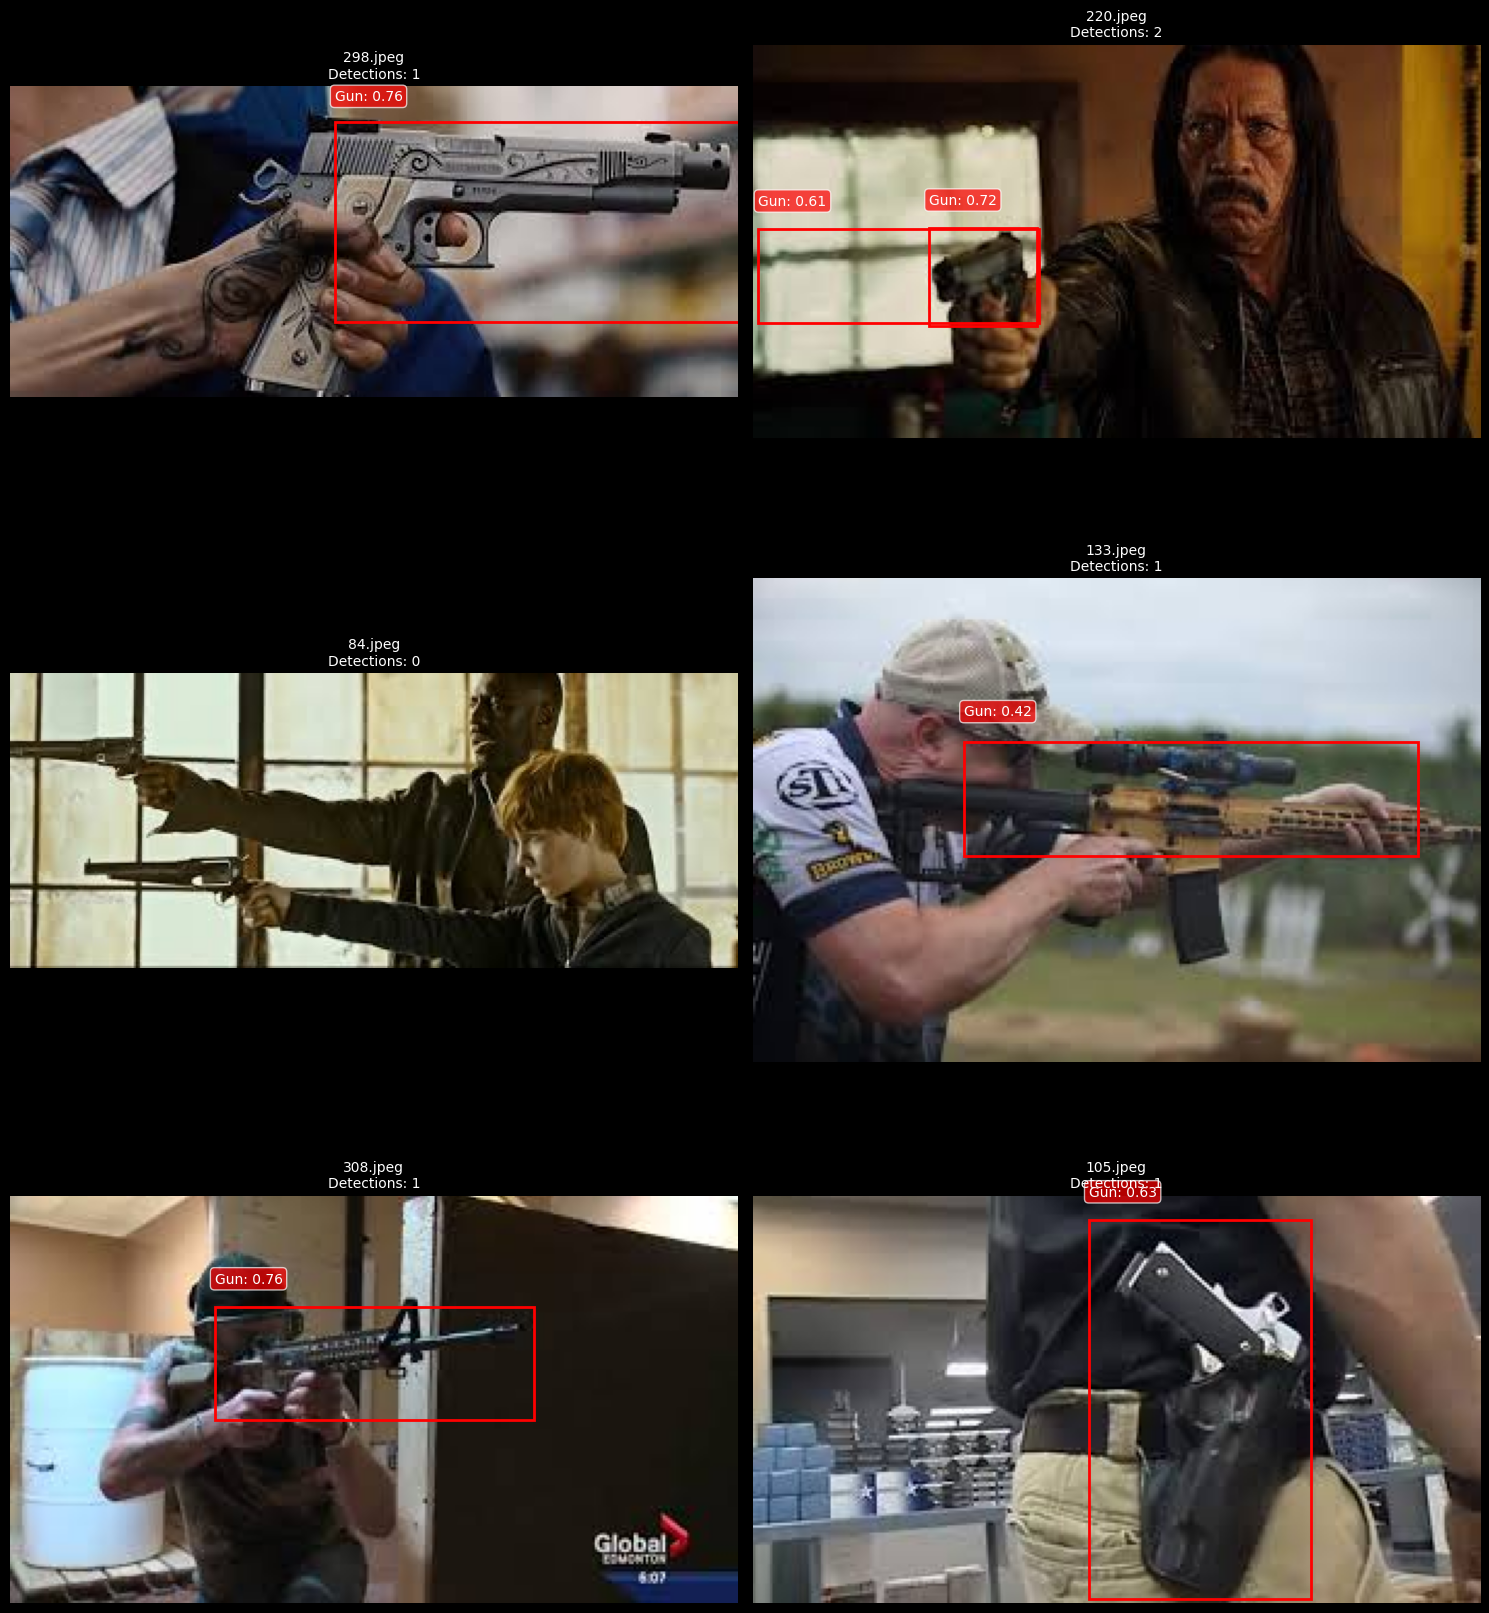


Visualization saved as 'gun_detection_results.png'


In [7]:
# Test on sample images
test_images_dir = f"{dataset_path}/test/images"
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpeg")][:6]

# Create visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.ravel()

for idx, img_file in enumerate(test_images):
    if idx >= 6:  # Limit to 6 images
        break

    img_path = os.path.join(test_images_dir, img_file)

    # Run inference
    results = best_model(img_path, device=device, verbose=False)

    # Load and display image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img)
    axes[idx].set_title(f"Detection Result: {img_file}", fontsize=12)
    axes[idx].axis("off")

    # Draw bounding boxes
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        detection_count = 0

        for i in range(len(boxes)):
            # Get box coordinates and confidence
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = boxes.conf[i].cpu().numpy()

            # Only show detections with confidence > 0.3
            if conf > 0.3:
                detection_count += 1

                # Draw rectangle
                rect = plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    linewidth=2,
                    edgecolor="red",
                    facecolor="none",
                )
                axes[idx].add_patch(rect)

                # Add confidence label
                axes[idx].text(
                    x1,
                    y1 - 10,
                    f"Gun: {conf:.2f}",
                    bbox=dict(boxstyle="round", facecolor="red", alpha=0.7),
                    fontsize=10,
                    color="white",
                )

        axes[idx].set_title(f"{img_file}\nDetections: {detection_count}", fontsize=10)
    else:
        axes[idx].set_title(f"{img_file}\nNo detections", fontsize=10)

plt.tight_layout()
plt.savefig("gun_detection_results.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nVisualization saved as 'gun_detection_results.png'")

In [8]:
# 최종 maP@0.5 평가

print(f"mAP@0.5: {metrics.box.map50:.4f}")

mAP@0.5: 0.8476


**Table of contents**<a id='toc0_'></a>    
- [컴퓨터비전-Object Detection 기말과제](#toc1_)    
  - [라이브러리 import 및 설정](#toc1_1_)    
  - [데이터 탐색](#toc1_2_)    
  - [YOLO 형식으로 변환](#toc1_3_)    
  - [YOLO11n 모델 로드 및 학습](#toc1_4_)    
  - [Model Evaluation](#toc1_5_)    
  - [Visualization and Testing](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->